# Times do brasileirão

# Autor
Nome: Samuel Nogueira Bacelar

Matrícula: 180130722

Github: [SamuelNoB](https://github.com/SamuelNoB)

# Objetivo

O objetivo deste artigo é o de criar um modelo capaz de reconhecer e diferenciar os times do Brasileirão serie A de 2023. Os times do brasileirão 2023 são: Corinthians, Palmeiras, Santos,  São Paulo, Red Bull Bragantino, Botafogo, Flamengo, Fluminense, Vasco, América-MG, Atlético-MG, Cruzeiro, Athletico-PR, Coritiba, Grêmio, Internacional, Bahia, Fortaleza e Goiás.

Além disso realizar o deploy no Huggin face

## Passo 1: Baixar imagens de diferentes times

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term: str, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Iniciamos produrando por imagens de pessoas de cabelo crespo

In [15]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('Palmeiras players', max_images=3)
urls[0]


Searching for 'Palmeiras players'


'https://futebolatino.lance.com.br/wp-content/uploads/2016/10/Palmeiras.jpeg'

Então baixamos uma imagem poder visualiza-la

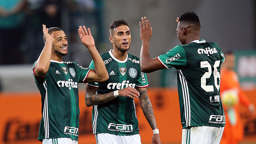

In [61]:
from fastdownload import download_url
dest = 'palmeiras.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Então procuramos pelos quatro tipos principais de cabelos, em ambos os sexos e com plano de fundo fora e dentro de um ambiente interno.

In [21]:
times_serie_a = ['Corinthians', 'Palmeiras', 'Santos', 
                'São Paulo', 'Red Bull Bragantino', 'Botafogo', 
                'Flamengo', 'Fluminense', 'Vasco', 'América-MG', 
                'Atlético-MG', 'Cruzeiro', 'Athletico-PR', 'Coritiba', 
                'Grêmio', 'Internacional', 'Bahia', 'Fortaleza', 'Goiás'
                ]
path = Path('teams')
from time import sleep

for o in times_serie_a:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} player'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} players'))
    sleep(5)
    resize_images(path/o, max_size=600, dest=path/o)

Searching for 'Santos Futebol Clube player'
Searching for 'Santos Futebol Clube players'


## Passo 2: Treinando o modelo

Primeiro é necessário remover fotos que tiveram erros no momento do download de modo a não impactar o treinamento do modelo

In [22]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

Para treinar um modelo, precisaremos de `DataLoaders`, que é um objeto que contém um **conjunto de treinamento** (as imagens usadas para criar um modelo) e um **conjunto de validação** (as imagens usadas para verificar a precisão de um modelo - não usado durante o treinamento). No `fastai`, podemos criar isso facilmente usando um `DataBlock` e visualizar imagens de amostra a partir dele:

In [23]:
teams = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)


Aqui está o que cada um dos parâmetros `DataBlock` significa:

    blocks=(ImageBlock, CategoryBlock),

As entradas para o nosso modelo são imagens e as saídas são categorias (neste caso, "pássaro" ou "floresta").

    get_items=get_image_files,

Para encontrar todas as entradas para o nosso modelo, execute a função `get_image_files` (que retorna uma lista de todos os arquivos de imagem em um caminho).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Divida os dados em conjuntos de treinamento e validação aleatoriamente, usando 20% dos dados para o conjunto de validação.

    get_y=parent_label,

Os rótulos (valores `y`) são o nome do `pai` de cada arquivo (ou seja, o nome da pasta em que estão, que será *pássaro* ou *floresta*).

    item_tfms=[Resize(192, method='squish')]

Antes do treinamento, redimensione cada imagem para 192x192 pixels "espremendo-a" (em vez de cortá-la).

Agora estamos prontos para treinar nosso modelo. O modelo de visão computacional mais rápido e amplamente utilizado é o `resnet50`. Você pode treiná-lo em poucos minutos, mesmo em uma CPU! (Em uma GPU, geralmente leva menos de 10 segundos...)

O `fastai` vem com um método útil `fine_tune()` que automaticamente usa as melhores práticas para ajustar um modelo pré-treinado, então usaremos isso.

### configurações adicionais
As duas células forçam a execução do garbage collector e do cache e tambem faz com que o output do resultado dos modelos treinados sejam exibidos corretamente.

In [24]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()


840

In [25]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

### Data augmentation
A fim de melhorar o desempenho do treinamento, uma estratégia de transformação das imagens será usada.

O **Data augmentation** é a criação de variações aleatórias dos dados de entrada, de tal forma que elas aparentem ser diferentes, apesar de serem a mesma imagem.

Algumas informações sobre métodos e funções usadas: 
- *aug_transforms()* é um padrão de augmentations indicado na aula e com boa performance para imagens de fotos naturais.
- *batch_tfms* é um método do fastai que indica o uso dessas transformações.
- *RandomResizedCrop*: Recorta e redimenciona de maneira aleátoria a imagem

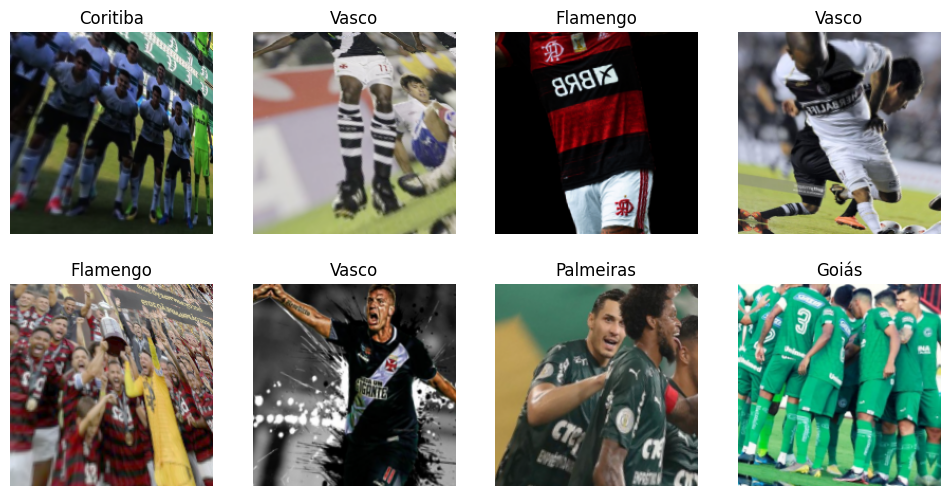

In [26]:
teams = teams.new(
    item_tfms=RandomResizedCrop(192, min_scale=0.5), 
    batch_tfms=aug_transforms(mult=2))
teams_dls = teams.dataloaders(path, bs=32, pin_memory=False)
teams_dls.train.show_batch(max_n=8, nrows=2, unique=False)

### Treinando
Aqui treinamos nosso modelo com um total de 4 iterações.

In [27]:
learn = vision_learner(teams_dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.028986,1.736672,0.447115,00:13
1,1.752489,1.592354,0.360577,00:12
2,1.448886,1.450246,0.317308,00:13
3,1.145630,1.383393,0.326923,00:13


## Limpando o modelo
Para diminuir as perdas e reduzir a taxa de erro podemos limpar o modelo. Primeiro geraremos uma matriz de confusão para ver quais erros estão sendo cometidos pelo modelo, quais os tipos de cabelo que ele mais confunde.


### Matriz de confusão


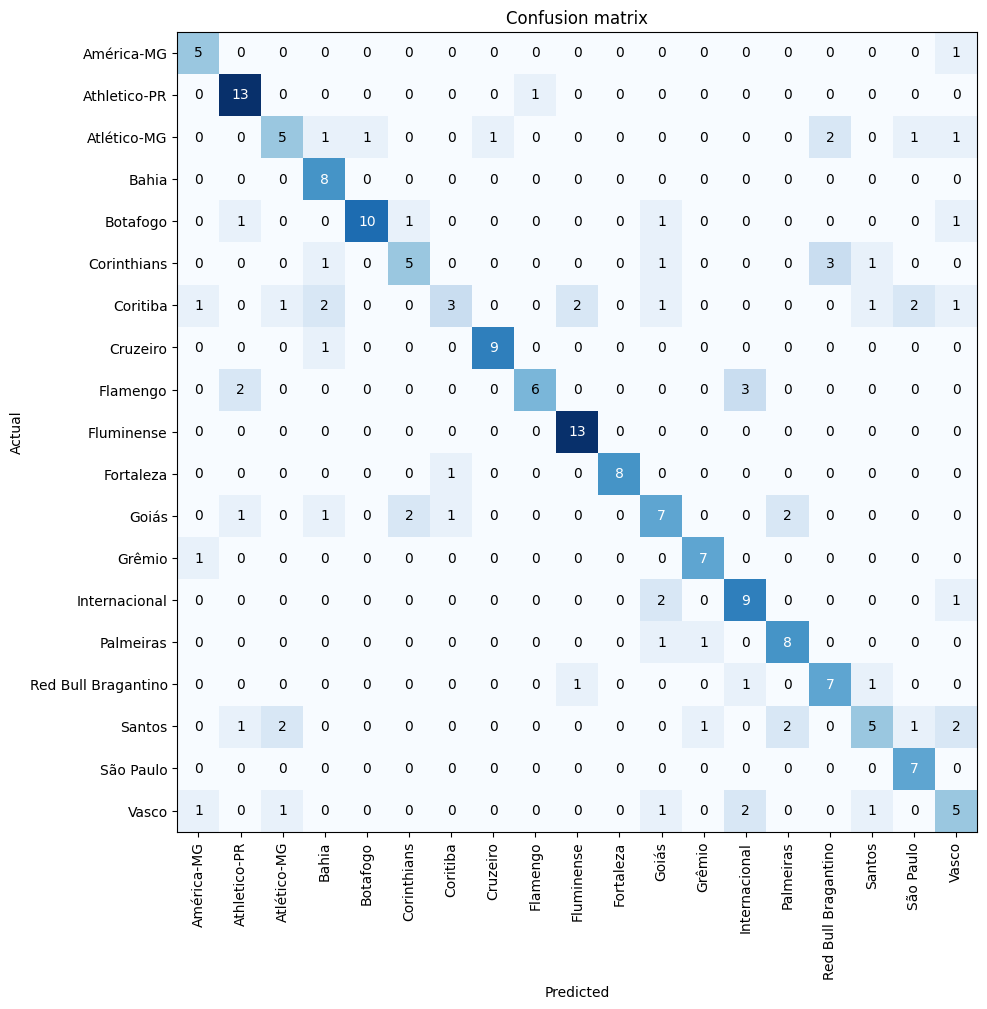

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

As colunas da matriz representam as imagens de tipos de cabelo que o modelo prediz, e as linhas representam o conjunto de imagens de tipos de cabelo utilizadas no treinamento.

A diagonal principal representa os acertos (predição condiz com a label). Enquanto as outras intercessões mostram os erros cometidos, sendo quanto maior o número de uma celula mais vezes ocorreu a confusão.

Para entender melhor o que os erros mostram (um erro do modelo ou das imagens) pode ser útil ordenar as imagens pela perda (loss).

**Quanto mais incorreto é o modelo maior a perda (loss)**, especialmente quando o erro ocorre com alta confiança. A perda (loss) também é alta quando a predição está correta porém com pouca confiança na resposta.

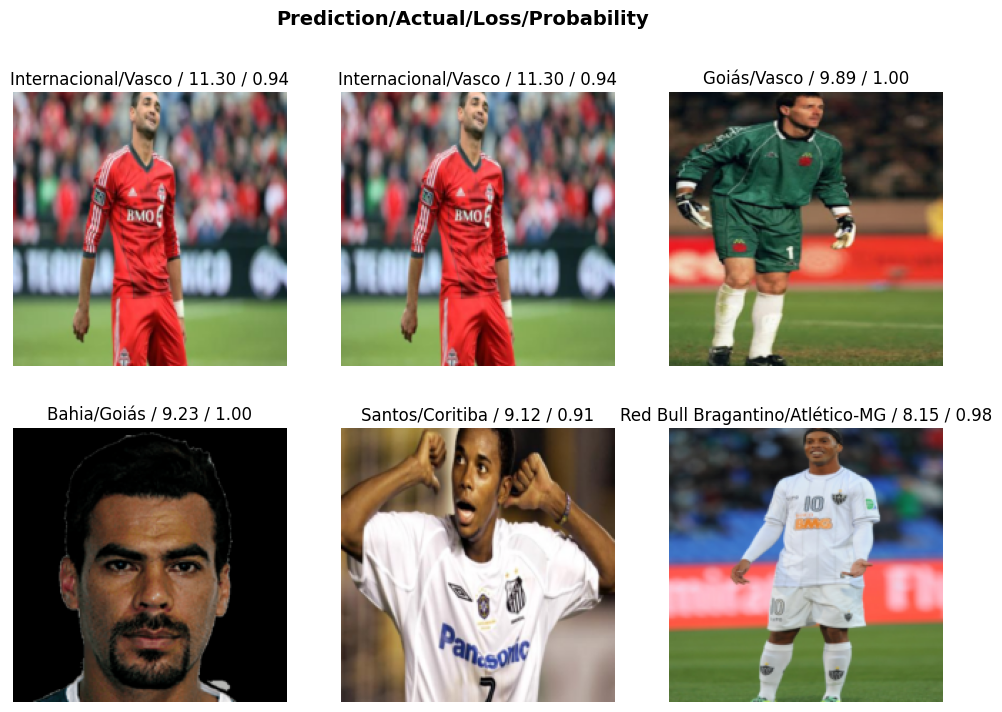

In [29]:
interp.plot_top_losses(6, figsize=(12,8))

Após esse processo o modelo auxiliou a identificar onde o dado pode ser mais problemático de maneira rápida.

Para melhorar o conjunto de dados é preciso fazer uma **limpeza dos dados**. O fastai possui uma GUI para isso chamada *ImageClassifierCleaner*, essa GUI será usada para selecionar imagens para remoção ou realocar.

In [60]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)
cleaner

Para realizar as remoções e realocamento das imagens indicadas basta utilizar esses 2 loops:

In [46]:

for idx in cleaner.delete(): 
    print("deletando: ", cleaner.fns[idx])
    cleaner.fns[idx].unlink()

for idx,cat in cleaner.change():
    print("movendo: ", cleaner.fns[idx], '\nPara: ', path/cat)
    shutil.move(str(cleaner.fns[idx]), path/cat)

deletando:  teams/Red Bull Bragantino/a2815d47-5b9a-4bf3-968b-62d23d529a33.jpg


### Treinando novamente
Uma vez que ocorre a limpeza dos dados, o modelo pode ser **re-treinado** a fim de alcançar melhores resultados.
ps: Remova os comentários para rodar este trecho após realizar a limpeza de dados

In [56]:
teams_dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32, pin_memory=False)


In [57]:
learn = vision_learner(teams_dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.048248,1.086944,0.275000,00:13
1,0.624095,1.255353,0.290000,00:12
2,0.386225,1.090693,0.285000,00:12
3,0.239304,1.048121,0.265000,00:12


## Passo 3: Testando o modelo

Com o modelo treinado, basta executar a última tela e será retornado um prompt informando qual é time da pessoa na foto, uma probabilidade de ser o time predito e a imagem inserida.

Time: Flamengo.
Probabilidade de ser do tipo Flamengo: 98.60%


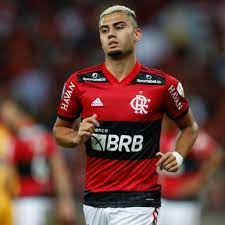

In [64]:
prediction_photo='flamengo.jpg'

team,_,probs = learn.predict(PILImage.create(prediction_photo))
print(f"Time: {team}.")
print(f"Probabilidade de ser do tipo {team}: {probs.sort()[0][-1]*100:.2f}%")
Image.open(prediction_photo).to_thumb(480,480)

# Deploy

## Código de deploy
Foi realizado o deploy no hugging Face No seguinte link
```python
import gradio as gr
from fastai.vision.all import *

learn = load_learner('export.pkl')
labels = learn.dls.vocab

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

title = "Times brasileirão"
examples = ['vasco.jpg', 'sao paulo.jpg', 'bragantino.jpg', 'flamengo.jpg', 'palmeiras.jpg']

iface = gr.Interface(
    fn=classify_image,
    inputs=gr.inputs.Image(shape=(512, 512)),
    outputs=gr.outputs.Label(num_top_classes=3),
    title=title,
    examples=examples,
    )
iface.launch(inline=False)
```

In [62]:
learn.path = Path('.')
learn.export("export")

# Conclusão
Para aprimorar a acurácia do modelo foi necessário separar manualmente os dados usados para o treinamento. Nos primeiros treinamentos a taxa de erros chegava a ser de 32% e a separação manual melhorou a acurácia do modelo. Com isso, verifica-se que, a qualidade da classificação dos dados de treinamento impacta diretamente na assertividade do modelo.

O ambiente publicado pode ser acessado neste link https://huggingface.co/spaces/SamuelNog/times_brasileirao